# BBM409 - Machine Learning Laboratory #
## Assignment 3 #
### Introduction ###
Sentiment analysis, an important task in natural language processing, aims to identify the emotional tone behind textual content. In this project, we consider sentiment classification on a large-scale, balanced Amazon product review dataset consisting of 72,500 entries. Reviewers rate their reviews with stars (1 to 5). 1 and 2 stars are considered negative, 4 and 5 are considered positive, and 3 stars are considered neutral. The level of negativity and positivity of a review is used as a weighting factor.

Our primary goal is to distinguish between positive and negative reviews (excluding neutral examples) by leveraging both traditional bag-of-words approaches and semantic vectorization techniques.

We implement a custom Naive Bayes classifier from scratch, evaluating its performance in unigram, bigram, and trigram settings. Beyond classification, we investigate how n-gram granularity affects model accuracy, interpretability, and error types. Finally, we extend our analysis by evaluating a suite of bonus models—including an in-domain Word2Vec embedding with Logistic Regression, a FastText sub-word model, TF-IDF features (unigram+bigram) with both Logistic Regression and Linear SVM, pre-trained GloVe vectors, and a hybrid TF-IDF‖Word2Vec fusion—to compare how different sparse and dense representations, classifier choices, and fusion strategies impact overall performance and generalization.


In [1]:

# --------- environment setup  ---------
!pip install -q \
  pandas==2.2.3 \
  numpy==1.23.5 \
  matplotlib==3.9.4 \
  seaborn==0.13.2 \
  scikit-learn==1.6.1 \
  beautifulsoup4==4.12.3 \
  gensim==4.3.3 \
  nltk==3.9.1 \
  wordcloud==1.9.4


In [2]:
import sys
import re
import matplotlib
import sklearn
import time
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from wordcloud import WordCloud


warnings.filterwarnings('ignore')

# --- version information---
print("Python version:", sys.version)

print("pandas        :", pd.__version__)
print("numpy         :", np.__version__)
print("matplotlib    :", matplotlib.__version__)
print("seaborn       :", sns.__version__)
print("scikit-learn  :", sklearn.__version__)

Python version: 3.9.21 (main, Dec 11 2024, 10:21:40) 
[Clang 14.0.6 ]
pandas        : 2.2.3
numpy         : 1.23.5
matplotlib    : 3.9.4
seaborn       : 0.13.2
scikit-learn  : 1.6.1


In [3]:
# Matplotlib settings
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

Loading our dataset and checking some information regarding the dataset:

In [4]:
# Load data
df = pd.read_csv("amazon_reviews.csv")
# Convert star column to numeric value
df['Star'] = pd.to_numeric(df['Star'], errors='coerce')

print(f"Dataset Size: {df.shape}")
print("\nFirst 5 row:")
df.head()

Dataset Size: (72500, 3)

First 5 row:


Title  \
0                           Didn't work   
1  Worst nail product I have ever used.   
2                      Just didn't work   
3                                  Scum   
4                     Okay for cuticles   

                                             Content  Star  
0                         No change in nails at all.   1.0  
1  Garbage! Do not waste your $$$. My nails were ...   1.0  
2                            Nails are still brittle   1.0  
3                  Didn’t do any improvement at all.   1.0  
4  Helped cuticles, didn't do much for my nails. ...   1.0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72500 entries, 0 to 72499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Title    72480 non-null  object 
 1   Content  72493 non-null  object 
 2   Star     72500 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.7+ MB


In [6]:
df.describe()

Star
count  72500.000000
mean       3.000000
std        1.414223
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000

Below, we can see the distribution of star ratings in reviews:

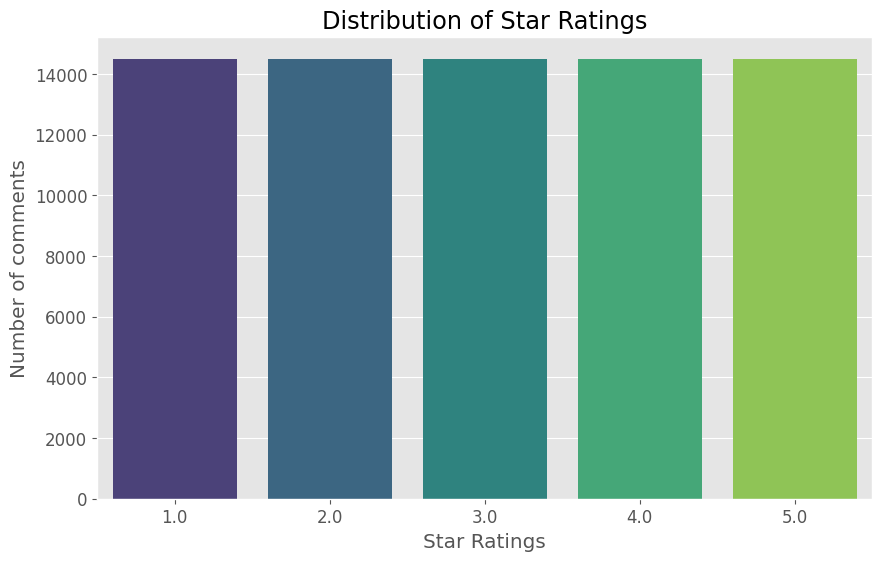

1.0 Star: 14500 Comment
2.0 Star: 14500 Comment
3.0 Star: 14500 Comment
4.0 Star: 14500 Comment
5.0 Star: 14500 Comment


In [7]:
# Distibution of stars 
plt.figure(figsize=(10, 6))
sns.countplot(x='Star', data=df, palette='viridis')  
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Ratings')
plt.ylabel('Number of comments')
plt.show()

star_counts = df['Star'].value_counts().sort_index() 
for star, count in star_counts.items():
    print(f"{star} Star: {count} Comment")

We need to convert star ratings to classes as negative, positive and neutral.

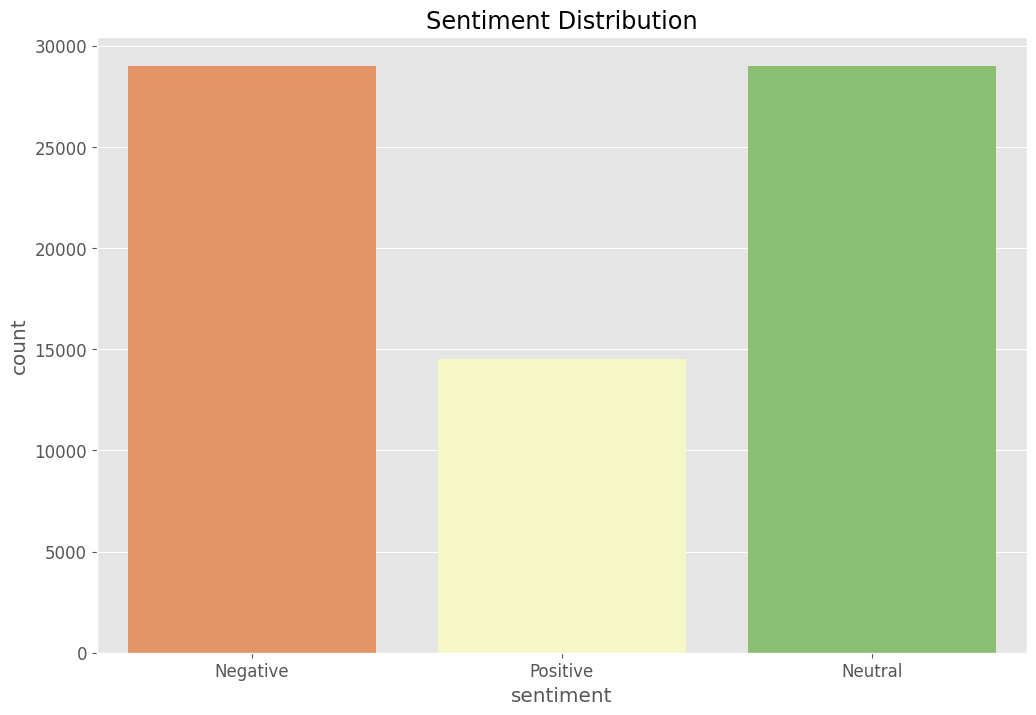

In [8]:
# Convert reviews to sentiment classes
def assign_sentiment(rating):
    if pd.isna(rating):  # Check for missing values
        return 'unknown'
    elif rating <= 2:
        return 'negative'
    elif rating >= 4:
        return 'positive'
    else:
        return 'neutral'

df['sentiment'] = df['Star'].apply(assign_sentiment)  

# Visualize class distribution
sns.countplot(x='sentiment', data=df, palette='RdYlGn')
plt.title("Sentiment Distribution")
plt.xticks([0, 1, 2], ["Negative", "Positive", "Neutral"])
plt.show()

After converting reviews to sentiment classes, we remove the neutral class since we decided that it will not be very helpful regarding the sentiment classification task, as it does not contribute strongly to distinguishing between clearly positive and negative opinions.

In [9]:
# Remove neutral class 
df_filtered = df[df['sentiment'] != 'neutral']

print("Filtered dataset size", df_filtered.shape)
print(df_filtered['sentiment'].value_counts())

Filtered dataset size (58000, 4)
sentiment
negative    29000
positive    29000
Name: count, dtype: int64


Sentiment-Intensity Weighting Rationale 

Stars 1–2 are mapped to the negative class, stars 4–5 to the positive class, while 3-star reviews are discarded as neutral. Within each polarity we differentiate sentiment strength: a 1-star opinion is typically harsher than a 2-star, and a 5-star review is usually more enthusiastic than a 4-star. To reflect this gradient without distorting class balance, we assign a weight of 1.0 to the stronger ratings (1 and 5) and 0.5 to the milder ratings (2 and 4). During training these weights scale the document counts that feed into the likelihood estimates of our Naive Bayes classifier, so that extreme reviews exert twice the influence of moderate ones while the overall positive-vs-negative ratio remains 1:1.

In [10]:
# Assign sentiment intensity weight based on the original star rating
def assign_weight(star):
    if star == 1.0:
        return 1.0  # strongly negative
    elif star == 2.0:
        return 0.5  # moderately negative
    elif star == 4.0:
        return 0.5  # moderately positive
    elif star == 5.0:
        return 1.0  # strongly positive
    else:
        return 0.0  # should not occur

df_filtered['weight'] = df_filtered['Star'].apply(assign_weight)


We need to see the relationship between the stars and title or content. For this process, we look at the title and content lenghts seperately.

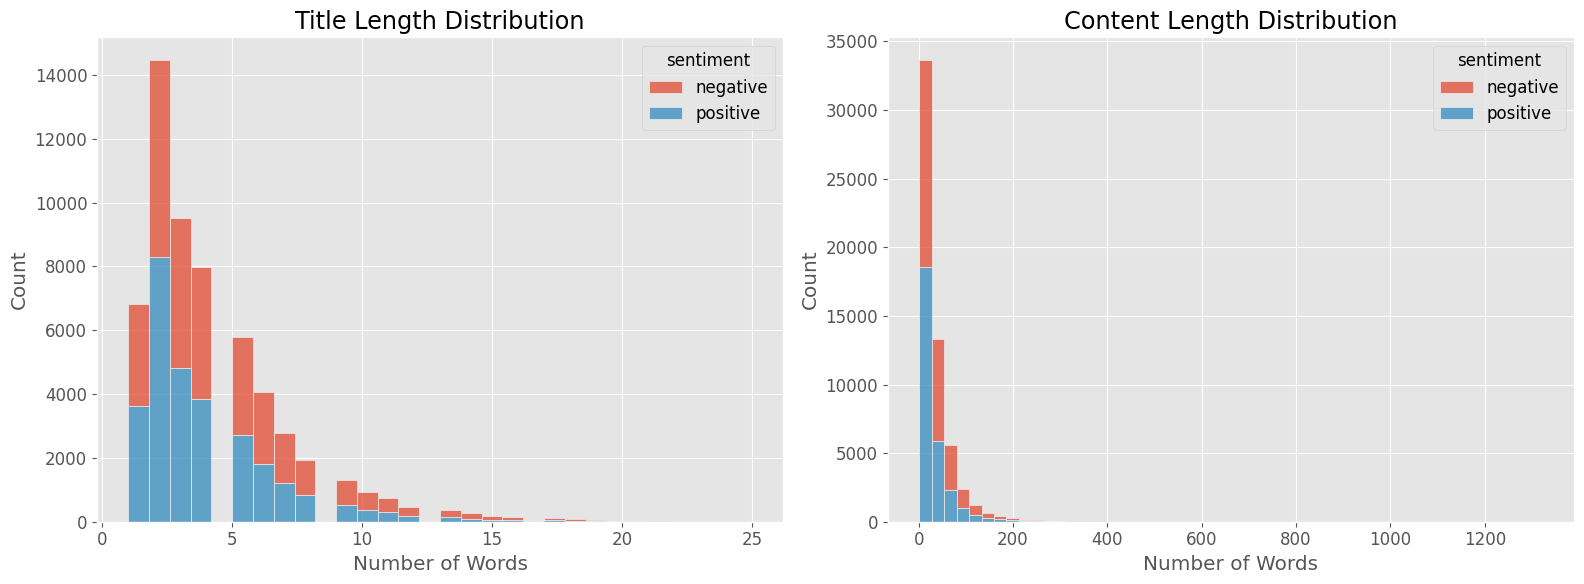

In [11]:
# Calculating title and content lengths
df_filtered['title_length'] = df_filtered['Title'].apply(lambda x: len(str(x).split()))
df_filtered['content_length'] = df_filtered['Content'].apply(lambda x: len(str(x).split()))

# Length distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=df_filtered, x='title_length', hue='sentiment', 
             multiple='stack', bins=30, ax=axes[0])
axes[0].set_title('Title Length Distribution')
axes[0].set_xlabel('Number of Words')

sns.histplot(data=df_filtered, x='content_length', hue='sentiment', 
             multiple='stack', bins=50, ax=axes[1])
axes[1].set_title('Content Length Distribution')
axes[1].set_xlabel('Number of Words')

plt.tight_layout()
plt.show()

In [12]:
# Statistics
print("Statistics of Title Length:")
print(df_filtered.groupby('sentiment')['title_length'].describe())
print("\nStatistics of Content Length:")
print(df_filtered.groupby('sentiment')['content_length'].describe())


Statistics of Title Length:
             count      mean       std  min  25%  50%  75%   max
sentiment                                                       
negative   29000.0  4.382172  3.079167  1.0  2.0  4.0  6.0  25.0
positive   29000.0  3.807414  2.719539  1.0  2.0  3.0  5.0  23.0

Statistics of Content Length:
             count       mean        std  min   25%   50%   75%     max
sentiment                                                              
negative   29000.0  39.505448  45.569924  1.0  13.0  26.0  50.0  1323.0
positive   29000.0  30.924483  41.744350  1.0   8.0  18.0  39.0  1094.0


We need to eliminate some common words like "the," "is," and "and" since they usually don’t have any relevance for analysis(These are known as stopwords). We also convert to lower case, remove HTML tags and special characters, clean up extra spaces. Basically, we clean the text to convert it to a state which we can process.

In [13]:
def preprocess_text(text, remove_stopwords=False):
    """Text cleaning and preprocessing function"""
   
    if not isinstance(text, str):
        return ""
    
    # Convert to lower case
    text = text.lower()
    
    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Clean up extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords 
    if remove_stopwords:
        stopwords = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 
                         'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 
                         'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 
                         'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 
                         'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 
                         'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 
                         'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 
                         'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
                         'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
                         'through', 'during', 'before', 'after', 'above', 'below', 'to', 
                         'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 
                         'again', 'further', 'then', 'once', 'here', 'there', 'when', 
                         'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 
                         'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 
                         'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 
                         'don', 'should', 'now'])
        text = ' '.join([word for word in text.split() if word not in stopwords])
    
    return text

We apply cleaning text process to both title and content and then, we combine them to process them together.

In [14]:
# Preprocessing
df_filtered['clean_title'] = df_filtered['Title'].apply(preprocess_text)
df_filtered['clean_content'] = df_filtered['Content'].apply(preprocess_text)
df_filtered['clean_text'] = df_filtered['clean_title'] + ' ' + df_filtered['clean_content']

# Let's show the first 5 rows of the cleaned data
df_filtered[['clean_title', 'clean_content', 'clean_text', 'sentiment']].head()

clean_title  \
0                           didnt work   
1  worst nail product i have ever used   
2                      just didnt work   
3                                 scum   
4                    okay for cuticles   

                                       clean_content  \
0                          no change in nails at all   
1  garbage do not waste your my nails were worse ...   
2                            nails are still brittle   
3                    didnt do any improvement at all   
4  helped cuticles didnt do much for my nails i g...   

                                          clean_text sentiment  
0               didnt work no change in nails at all  negative  
1  worst nail product i have ever used garbage do...  negative  
2            just didnt work nails are still brittle  negative  
3               scum didnt do any improvement at all  negative  
4  okay for cuticles helped cuticles didnt do muc...  negative

#### Word Cloud Visualizations

To better understand the most frequent terms in each sentiment class, we generated word clouds from the preprocessed text. These visualizations help highlight dominant keywords that appear in positive and negative reviews.

* Frequently used terms such as "good", "great", "love" and "easy" are seen to have a high frequency in positive comments.
 
* In negative comments, words such as "one use", "product", "work", and "good" are often seen to be frequently used.

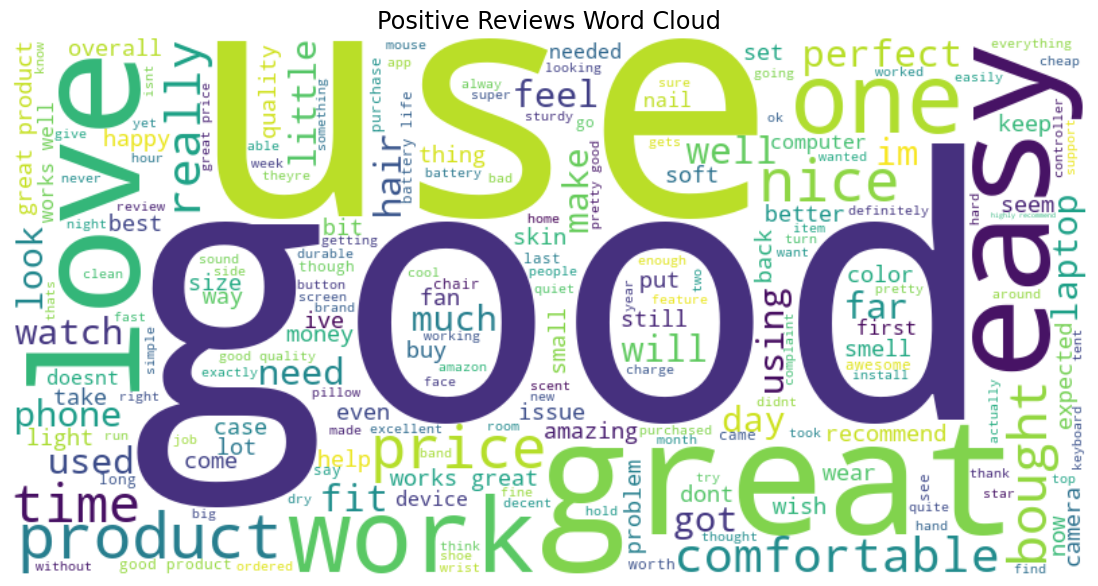

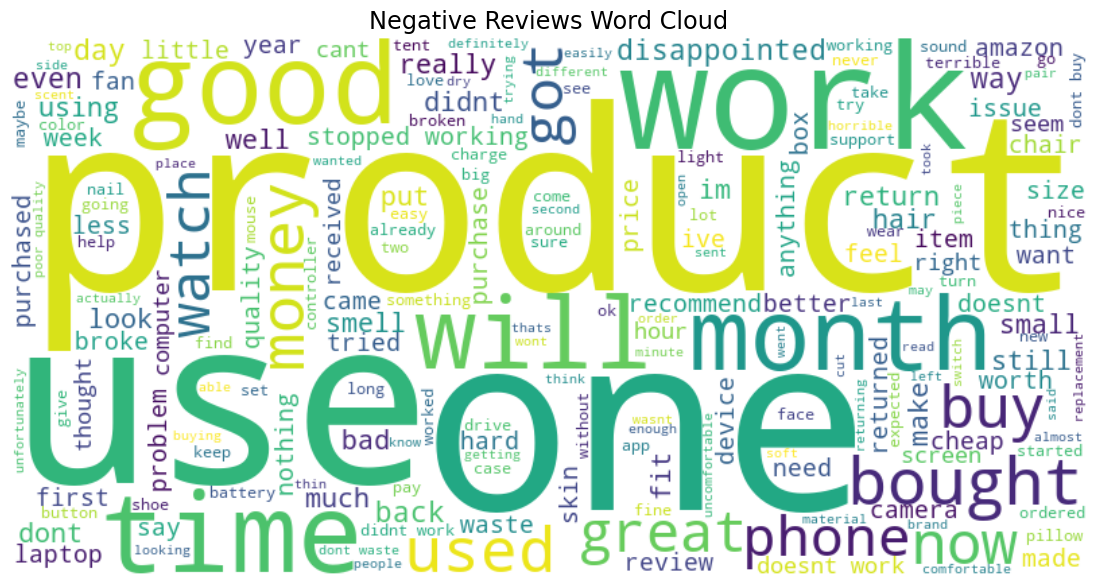

In [15]:
# Word cloud of positive and negative reviews.

for sentiment in ['positive','negative']:
    text = ' '.join(df_filtered[df_filtered['sentiment']==sentiment]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(15,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment.capitalize()} Reviews Word Cloud')
    plt.show()


Below we are creating a word cloud for all comments.

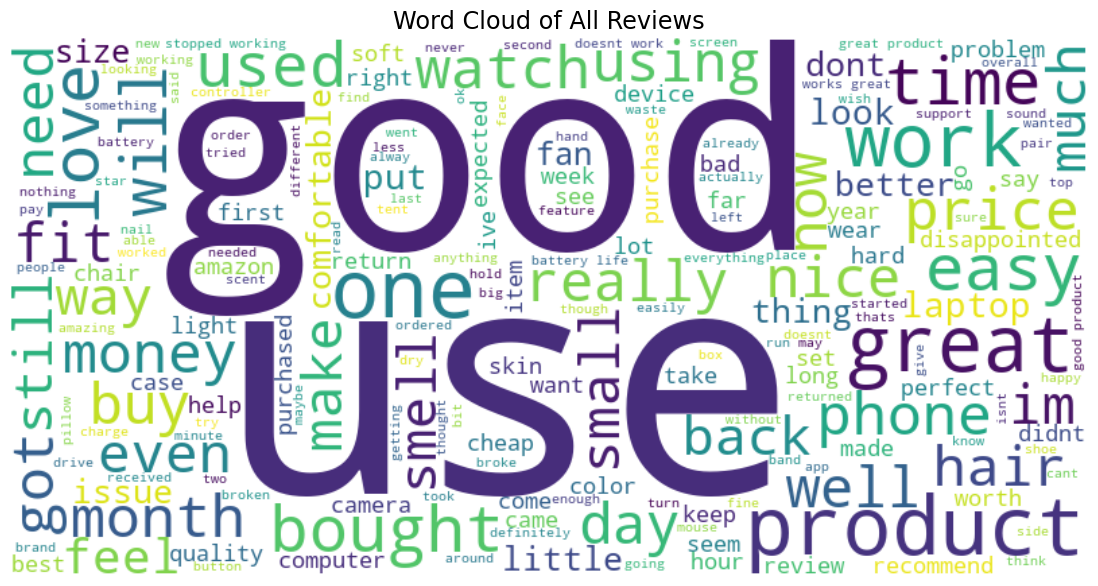

In [16]:
# Word cloud of all reviews.
from wordcloud import WordCloud

all_text = ' '.join(df_filtered['clean_text'])
wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Reviews')
plt.show()


---
We need to split the data as training(80%) and testing(20%) sets. We use training set to train and use testing set to test our model's accuracy, precision etc.

In [17]:
# Split into training and test sets (80% training, 20% testing)
X = df_filtered['clean_text']
y = df_filtered['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train Set: {X_train.shape[0]} sample")
print(f"Test Set: {X_test.shape[0]} sample")
print(f"Sentiment distribution of training set:\n{y_train.value_counts()}")
print(f"Sentiment distribution of test set:\n{y_test.value_counts()}")

Train Set: 46400 sample
Test Set: 11600 sample
Sentiment distribution of training set:
sentiment
negative    23200
positive    23200
Name: count, dtype: int64
Sentiment distribution of test set:
sentiment
negative    5800
positive    5800
Name: count, dtype: int64


## Custom N-Gram + Naive Bayes Classifier

In this section, we implement our own Naive Bayes classifier tailored for text data represented with n-gram features. The process consists of two major components:

- **VocabularyBuilder**: This class is responsible for converting raw text into a bag-of-words (BoW) representation using n-grams. It first extracts n-grams from the training data, filters rare ones based on a minimum count, and builds a vocabulary index. During transformation, it converts new text into count vectors matching the learned vocabulary.

- **NaiveBayes**: This class implements a probabilistic classifier based on Bayes’ theorem. It calculates prior probabilities for each class and conditional probabilities for each word given the class. To avoid numerical instability, all computations are done in log space. Additionally, Laplace smoothing is used to handle unseen n-grams, and training samples can be weighted to reflect the intensity of sentiment.

Together, these classes enable us to build unigram, bigram, and trigram models from scratch, without relying on libraries like sklearn for core modeling logic. The classifier then predicts the class with the highest posterior probability given an input document's n-gram features.


In [18]:

class VocabularyBuilder:
    """Class to build and vectorize n-gram vocabulary for BoW representation."""
    
    def __init__(self, n_gram=1, min_count=2):
        self.n_gram = n_gram
        self.min_count = min_count
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.word_counts = Counter()
        self.vocab_size = 0
        
    def _extract_n_grams(self, text):
        words = text.split()
        if self.n_gram == 1:
            return words
        return [' '.join(words[i:i+self.n_gram]) for i in range(len(words) - self.n_gram + 1)]
    
    def fit(self, texts):
        for text in texts:
            n_grams = self._extract_n_grams(text)
            self.word_counts.update(n_grams)
        filtered = [w for w, c in self.word_counts.items() if c >= self.min_count]
        for idx, word in enumerate(filtered):
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word
        self.vocab_size = len(self.word_to_idx)
        self._finalize_with_unk()
        
    def transform(self, texts):
        X = np.zeros((len(texts), self.vocab_size), dtype=np.float32)
        for i, text in enumerate(texts):
            n_grams = self._extract_n_grams(text)
            for gram in n_grams:
                # Map unseen n-grams to the '<unk>' index
                idx = self.word_to_idx.get(gram, self.word_to_idx['<unk>'])
                X[i, idx] += 1
        return X
    
    def fit_transform(self, texts):
        self.fit(texts)
        return self.transform(texts)

    def _finalize_with_unk(self):
        """
        After building the vocabulary:
        • Aggregate every n-gram whose count is < min_count into a single '<unk>' token
        • Ensure that '<unk>' is always present in the dictionary
        """
        # 1) Sum counts of n-grams that have NOT been inserted because they were too rare
        unk_count = sum(c for w, c in self.word_counts.items()
                        if w not in self.word_to_idx)

        # 2) Add the '<unk>' entry
        self.word_to_idx['<unk>'] = len(self.word_to_idx)
        self.idx_to_word[self.word_to_idx['<unk>']] = '<unk>'
        self.word_counts['<unk>'] = unk_count
        self.vocab_size = len(self.word_to_idx)


We compute all class-conditional probabilities in log space to avoid numerical underflow.
Every n-gram’s count is smoothed with Laplace smoothing (α = 1), and any token that is rare during training or completely unseen at test-time is mapped to a dedicated <unk> token, ensuring it receives a well-defined (non-zero) probability.

In [19]:
class NaiveBayes:
    """Naive Bayes classifier using log probabilities and Laplace smoothing."""
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.class_word_probs = {}
        self.classes = None
        self.vocab_size = 0
        
    def fit(self, X, y, sample_weights=None):
        self.classes = np.unique(y)
        self.vocab_size = X.shape[1]
        n_samples = len(y)
    
        if sample_weights is None:
            sample_weights = np.ones(n_samples)
    
        # Compute class priors with sample weights
        for c in self.classes:
            class_mask = (y == c)
            class_weight_sum = np.sum(sample_weights[class_mask])
            self.class_priors[c] = np.log(class_weight_sum / np.sum(sample_weights))
    
        for c in self.classes:
            X_c = X[y == c]
            weights_c = sample_weights[y == c]
    
            # Compute weighted word counts with Laplace smoothing
            weighted_counts = np.dot(weights_c, X_c) + self.alpha
            total_words = np.sum(weighted_counts)
            self.class_word_probs[c] = np.log(weighted_counts / total_words)

    def predict_proba(self, X):
        n_samples = X.shape[0]
        proba = np.zeros((n_samples, len(self.classes)))
        
        for i, c in enumerate(self.classes):
            log_prior = self.class_priors[c]
            log_likelihood = self.class_word_probs[c]
            for j in range(n_samples):
                word_indices = X[j] > 0
                word_counts = X[j, word_indices]
                log_sum = np.sum(word_counts * log_likelihood[word_indices])
                proba[j, i] = log_prior + log_sum
        
        # Softmax for normalization
        proba_exp = np.exp(proba - np.max(proba, axis=1, keepdims=True))
        proba_norm = proba_exp / np.sum(proba_exp, axis=1, keepdims=True)
        return proba_norm
    
    def predict(self, X):
        return self.classes[np.argmax(self.predict_proba(X), axis=1)]


In [20]:
def evaluate_model(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    classes = np.unique(y_true)

    metrics = {}
    for cls in classes:
        TP = np.sum((y_true == cls) & (y_pred == cls))
        FP = np.sum((y_true != cls) & (y_pred == cls))
        FN = np.sum((y_true == cls) & (y_pred != cls))

        precision = TP / (TP + FP) if (TP + FP) else 0
        recall    = TP / (TP + FN) if (TP + FN) else 0
        f1        = 2*precision*recall/(precision+recall) if (precision+recall) else 0

        metrics[cls] = dict(precision=precision,
                            recall=recall,
                            f1=f1,
                            support=np.sum(y_true == cls))

    total = len(y_true)
    weighted = lambda m: sum(v[m]*v['support'] for v in metrics.values()) / total
    accuracy = np.mean(y_true == y_pred)

    

    return dict(accuracy=accuracy,
                precision=weighted('precision'),
                recall=weighted('recall'),
                f1=weighted('f1'))

In [21]:

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):

    cm = confusion_matrix(y_true, y_pred, labels=["negative", "positive"])
    
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set(xticks=[0,1], yticks=[0,1],
           xticklabels=["Negative","Positive"],
           yticklabels=["Negative","Positive"],
           xlabel="Predicted", ylabel="Actual",
           title=title)

    ax.grid(False)
    
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            color = "white" if val > thresh else "black"
            ax.text(j, i, f"{val:d}",
                    ha="center", va="center",
                    color=color, fontsize=12)
    
    plt.tight_layout()
    plt.show()


Now, it is time to train our model for unigram, bigram and trigram seperately. After training and getting results, we will compare the results.

In [22]:

print("Unigram model training is starting...")
start_time = time.time()

# Sample weights for training data
weights_train = df_filtered.loc[X_train.index, 'weight'].values

# Creating a Unigram vocabulary
unigram_builder = VocabularyBuilder(n_gram=1, min_count=3)
X_train_unigram = unigram_builder.fit_transform(X_train)
X_test_unigram = unigram_builder.transform(X_test)

# Training Naive Bayes
nb_unigram = NaiveBayes(alpha=1.0)
# Train model with weights
nb_unigram.fit(X_train_unigram, y_train, sample_weights=weights_train)

# Making predictions
y_pred_unigram = nb_unigram.predict(X_test_unigram)

print(f"\nUnigram model training time: {time.time() - start_time:.2f} second")


print("\nUnigram Model Performance Metrics:")
unigram_metrics = evaluate_model(y_test, y_pred_unigram)
pd.DataFrame([unigram_metrics], index=["Unigram"])



Unigram model training is starting...

Unigram model training time: 4.81 second

Unigram Model Performance Metrics:


accuracy  precision    recall       f1
Unigram  0.870862   0.871005  0.870862  0.87085

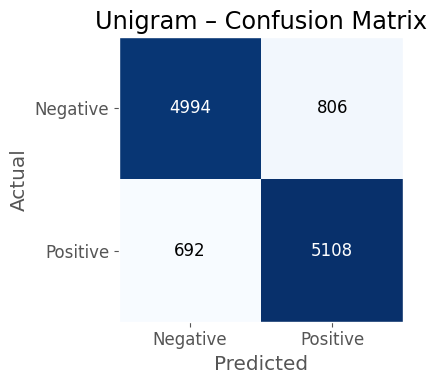

In [23]:
#Confusion matrix for unigram
plot_confusion_matrix(y_test, y_pred_unigram, "Unigram – Confusion Matrix")

In [24]:
print("\nBigram model training is starting...")
start_time = time.time()

# Creating a Bigram vocabulary
bigram_builder = VocabularyBuilder(n_gram=2, min_count=3)
X_train_bigram = bigram_builder.fit_transform(X_train)
X_test_bigram = bigram_builder.transform(X_test)

# Training Naive Bayes
nb_bigram = NaiveBayes(alpha=1.0)
# Train model with weights
nb_bigram.fit(X_train_bigram, y_train, sample_weights=weights_train)

# Making predictions
y_pred_bigram = nb_bigram.predict(X_test_bigram)

print(f"\nBigram model training time: {time.time() - start_time:.2f} second")

print("\nBigram Model Performance Metrics:")
bigram_metrics = evaluate_model(y_test, y_pred_bigram)
pd.DataFrame([bigram_metrics], index=["Bigram"])


Bigram model training is starting...

Bigram model training time: 32.68 second

Bigram Model Performance Metrics:


accuracy  precision    recall        f1
Bigram  0.894655   0.894912  0.894655  0.894638

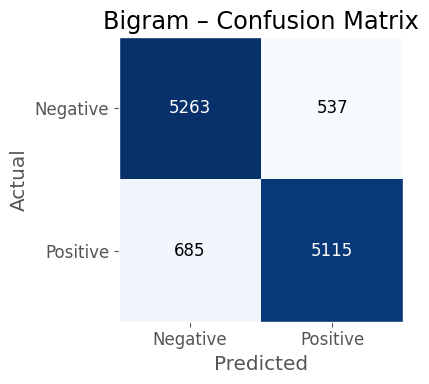

In [25]:
#Confusion Matrix for bigram
plot_confusion_matrix(y_test, y_pred_bigram, "Bigram – Confusion Matrix")

In [26]:
print("\nTrigram model training starting...")
start_time = time.time()

# Creating a Trigram vocabulary
bigram_builder = VocabularyBuilder(n_gram=3, min_count=3)
X_train_trigram = bigram_builder.fit_transform(X_train)
X_test_trigram = bigram_builder.transform(X_test)

# Naive Bayes modelini eğitme
nb_trigram = NaiveBayes(alpha=1.0)
# Train model with weights
nb_trigram.fit(X_train_trigram, y_train, sample_weights=weights_train)

# Making predictions
y_pred_trigram = nb_trigram.predict(X_test_trigram)

print(f"\nTrigram model training time: {time.time() - start_time:.2f} second")

print("\nTrigram Model Performance Metrics:")
trigram_metrics = evaluate_model(y_test, y_pred_trigram)
pd.DataFrame([trigram_metrics], index=["Trigram"])


Trigram model training starting...

Trigram model training time: 33.32 second

Trigram Model Performance Metrics:


accuracy  precision    recall        f1
Trigram  0.836121   0.844245  0.836121  0.835148

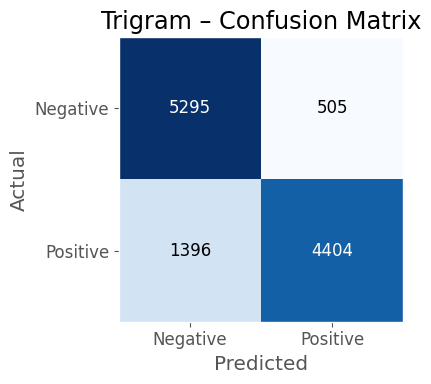

In [27]:
#Confusion Matrix for trigram
plot_confusion_matrix(y_test, y_pred_trigram, "Trigram – Confusion Matrix")

### Initial Discussion on Naive Bayes Results
As we can see from the results, all three models — Unigram, Bigram, and Trigram — achieve reasonably high accuracy and perform well overall. However, the Bigram model consistently outperforms the others across all metrics, including accuracy, precision, recall, and F1-score. This suggests that incorporating bigram-level context captures more meaningful patterns in the text compared to using individual words (unigrams) alone.

Interestingly, the performance of the Trigram model slightly drops compared to the Bigram model. This may be due to data sparsity or overfitting, which are common challenges when working with higher-order n-grams, especially when the dataset is not large enough to support reliable frequency estimates for longer sequences.

Additionally, as the value of n increases in n-gram models, training time grows significantly. This is expected, as the feature space becomes much larger with more combinations of word sequences, increasing both computational complexity and the risk of running into memory issues.

The Bigram model appears to offer the best trade-off between expressiveness and reliability in this setup.

To support these observations, the following section examines model behavior through detailed error analyses and qualitative review examples.



In [28]:
# Comparing results
models = ['Unigram', 'Bigram', 'Trigram']
metrics = ['accuracy', 'precision', 'recall', 'f1']
all_metrics = [unigram_metrics, bigram_metrics, trigram_metrics]

results_df = pd.DataFrame(index=models, columns=metrics)
for i, model in enumerate(models):
    for metric in metrics:
        results_df.loc[model, metric] = all_metrics[i][metric]

print("\nComparison of All Models:")
display(results_df.astype(float).round(4))



Comparison of All Models:


accuracy  precision  recall      f1
Unigram    0.8709     0.8710  0.8709  0.8708
Bigram     0.8947     0.8949  0.8947  0.8946
Trigram    0.8361     0.8442  0.8361  0.8351

Below, we can see the results more clearly.

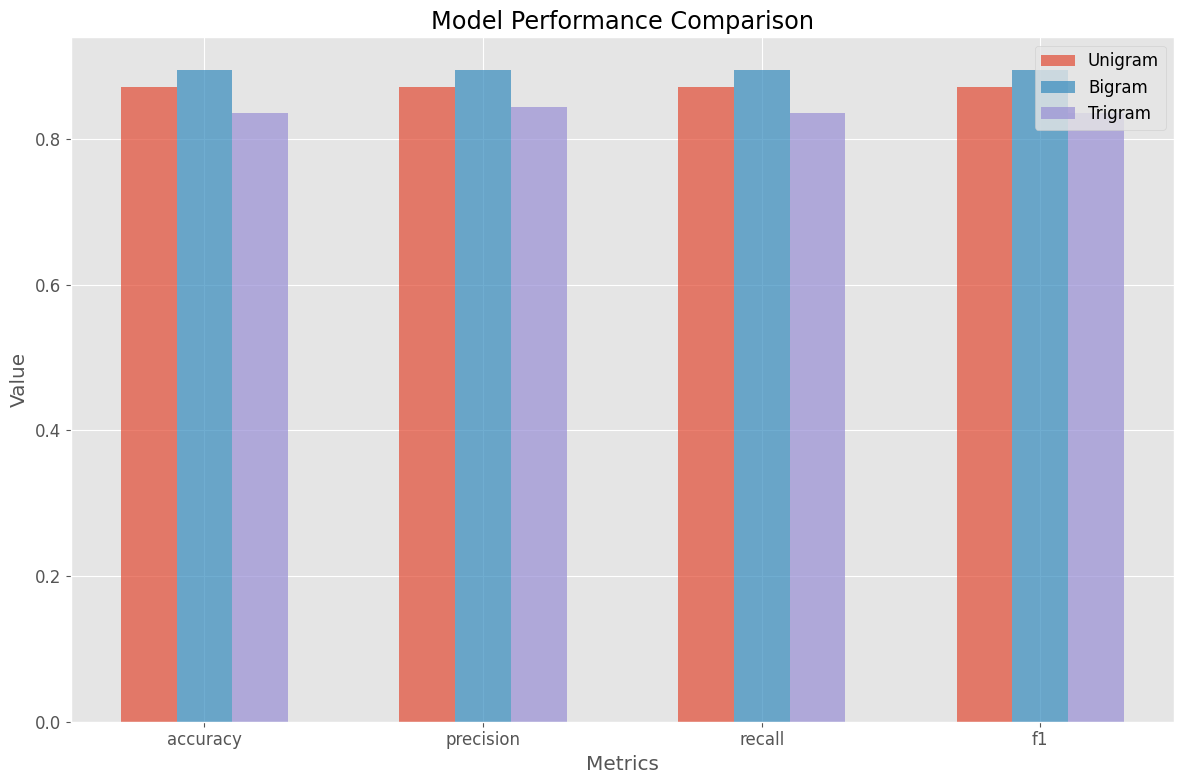

In [29]:
# Visualization
plt.figure(figsize=(12, 8))
bar_width = 0.2
index = np.arange(len(metrics))

for i, model in enumerate(models):
    plt.bar(index + i*bar_width, results_df.loc[model], bar_width, 
            label=model, alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Comparison')
plt.xticks(index + bar_width, metrics)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Unigram model - Error Analysis
error_data_unigram = []
y_test_array = np.array(y_test)
errors = np.where(y_test_array != y_pred_unigram)[0]
sample_errors = np.random.choice(errors, min(10, len(errors)), replace=False)

for idx in sample_errors:
    text = X_test.iloc[idx]
    true_label = y_test.iloc[idx]
    pred_label = y_pred_unigram[idx]
    error_data_unigram.append({
        "Index": idx,
        "Comment (truncated)": text[:300] + "...",
        "True Label": true_label,
        "Predicted Label": pred_label
    })

df_errors_unigram = pd.DataFrame(error_data_unigram)
display(df_errors_unigram)


Index                                Comment (truncated) True Label  \
0   9919  dont buy i wanted to love this so bad but it w...   negative   
1   5042  keeps falling off consi was so excited to get ...   positive   
2   9343  descent watch for price during the day has goo...   negative   
3   6818  buy something stronger not that powerful we go...   negative   
4  11592  battery life like the watches visual design it...   negative   
5   6111  very loud says is quite but its super loud i c...   negative   
6   4574   prefer the normal one buttons are super weird...   negative   
7   1121  all the bells and whistles you want its a soli...   positive   
8   3284  worksomg the smell but i need to follow direct...   positive   
9   8951  they work they work im giving a out of five be...   positive   

  Predicted Label  
0        positive  
1        negative  
2        positive  
3        positive  
4        positive  
5        positive  
6        positive  
7        negative  
8        negative  
9        negative

* The Unigram model struggles with negations, mixed signals, and lacks contextual awareness.

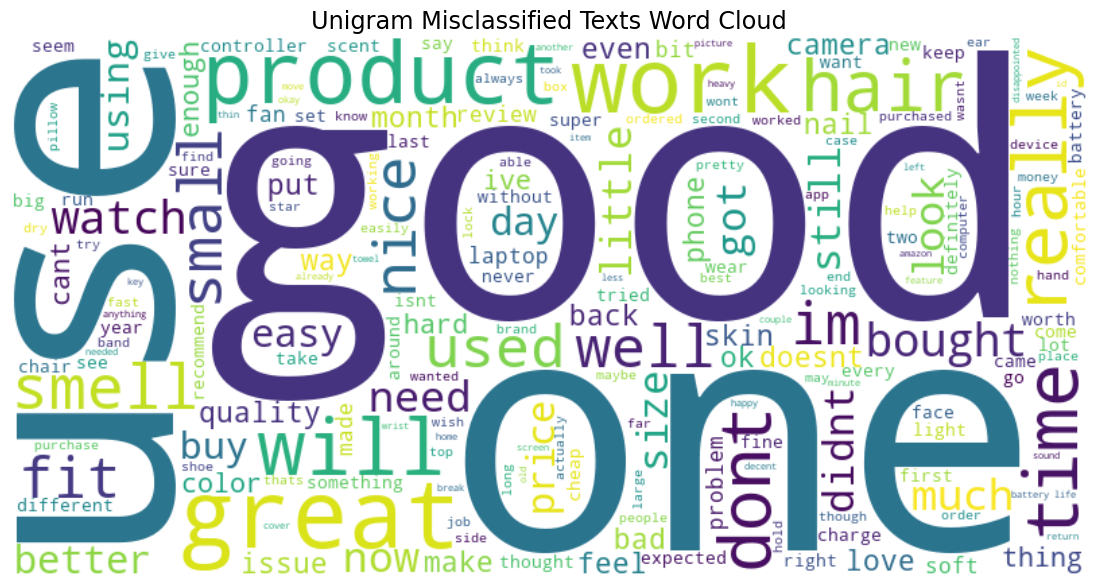

In [31]:
# Word cloud for all comments that the unigram model classified incorrectly
from wordcloud import WordCloud

mis_idx = np.where(y_test_array != y_pred_unigram)[0]
mis_text = ' '.join(X_test.iloc[mis_idx].tolist())

wc = WordCloud(width=800, height=400, background_color='white').generate(mis_text)
plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Unigram Misclassified Texts Word Cloud')
plt.show()


In [32]:
# Bigram model - Error Analysis
error_data_bigram = []
errors = np.where(y_test_array != y_pred_bigram)[0]
sample_errors = np.random.choice(errors, min(10, len(errors)), replace=False)

for idx in sample_errors:
    text = X_test.iloc[idx]
    true_label = y_test.iloc[idx]
    pred_label = y_pred_bigram[idx]
    error_data_bigram.append({
        "Index": idx,
        "Comment (truncated)": text[:300] + "...",
        "True Label": true_label,
        "Predicted Label": pred_label
    })

df_errors_bigram = pd.DataFrame(error_data_bigram)
display(df_errors_bigram)


Index                                Comment (truncated) True Label  \
0  11445  it good but you have to check it when arrive t...   negative   
1   5380  super stinky on fingers i have been wanting to...   negative   
2   7540     levi jeans for a relaxed fit they are tight...   negative   
3   4253  hair catching these look nice but they fail to...   negative   
4   1422  dont recommended dislikes its a bad shoes for ...   negative   
5  11053                               confiable chingon...   positive   
6   7998  not so good it doesnt have space for the butto...   negative   
7   9790  screen protector yes i like the product the on...   positive   
8  10905  teenagers who looses everything not sure got i...   positive   
9   7352  the band that comes with it is trash the band ...   positive   

  Predicted Label  
0        positive  
1        positive  
2        positive  
3        positive  
4        positive  
5        negative  
6        positive  
7        negative  
8        negative  
9        negative

* Bigram models improve contextual understanding but still struggle with nuanced or contradictory language.

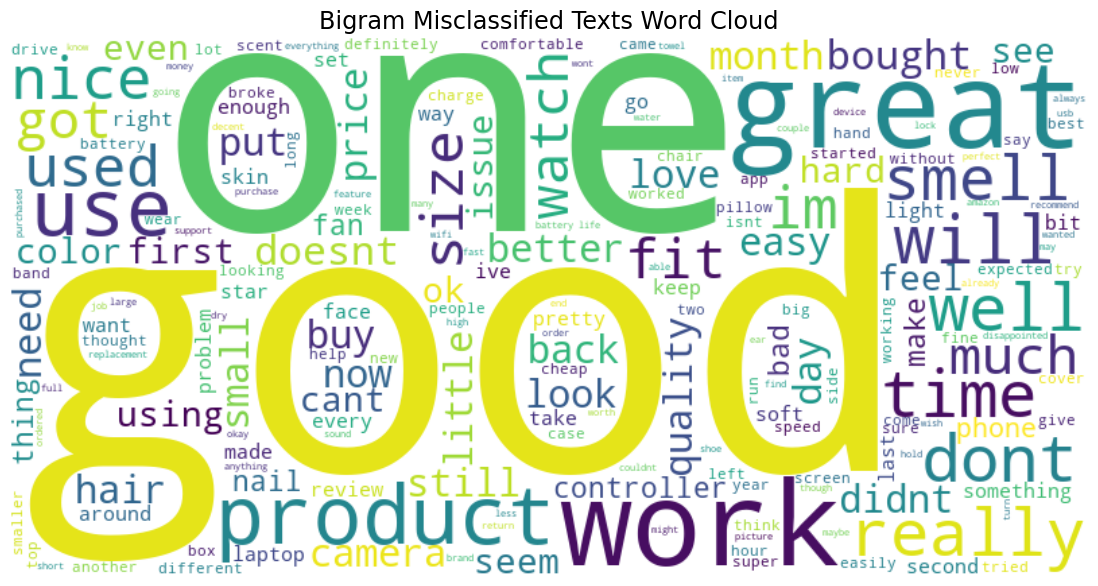

In [33]:
## Word cloud for all comments that the bigram model classified incorrectly
from wordcloud import WordCloud

mis_idx = np.where(y_test_array != y_pred_bigram)[0]
mis_text = ' '.join(X_test.iloc[mis_idx].tolist())

wc = WordCloud(width=800, height=400, background_color='white').generate(mis_text)
plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Bigram Misclassified Texts Word Cloud')
plt.show()


In [34]:
# Trigram model - Error Analysis
error_data_trigram = []
errors = np.where(y_test_array != y_pred_trigram)[0]
sample_errors = np.random.choice(errors, min(10, len(errors)), replace=False)

for idx in sample_errors:
    text = X_test.iloc[idx]
    true_label = y_test.iloc[idx]
    pred_label = y_pred_trigram[idx]
    error_data_trigram.append({
        "Index": idx,
        "Comment (truncated)": text[:300] + "...",
        "True Label": true_label,
        "Predicted Label": pred_label
    })

df_errors_trigram = pd.DataFrame(error_data_trigram)
display(df_errors_trigram)


Index                                Comment (truncated) True Label  \
0   5158                            works great daughter...   positive   
1   3252  great smaller pot for meals good safety featur...   positive   
2   2660  careful i gave this to my friend and she broke...   positive   
3   7142                             excellent excellent...   positive   
4   4277      ergonomic good noise level good for gaming...   positive   
5   1889  only works on popped pimples so heres the thin...   positive   
6   6519  nice it was easy and i was successful i follow...   positive   
7   2835  tablets is lock secured so much for buying new...   negative   
8  10495                                 amazing amazing...   positive   
9  10899  wheres the breeze laughable turbo if your look...   negative   

  Predicted Label  
0        negative  
1        negative  
2        negative  
3        negative  
4        negative  
5        negative  
6        negative  
7        positive  
8        negative  
9        positive

* Trigram model may suffer from data sparsity, overfitting, or missing rare but meaningful phrases.

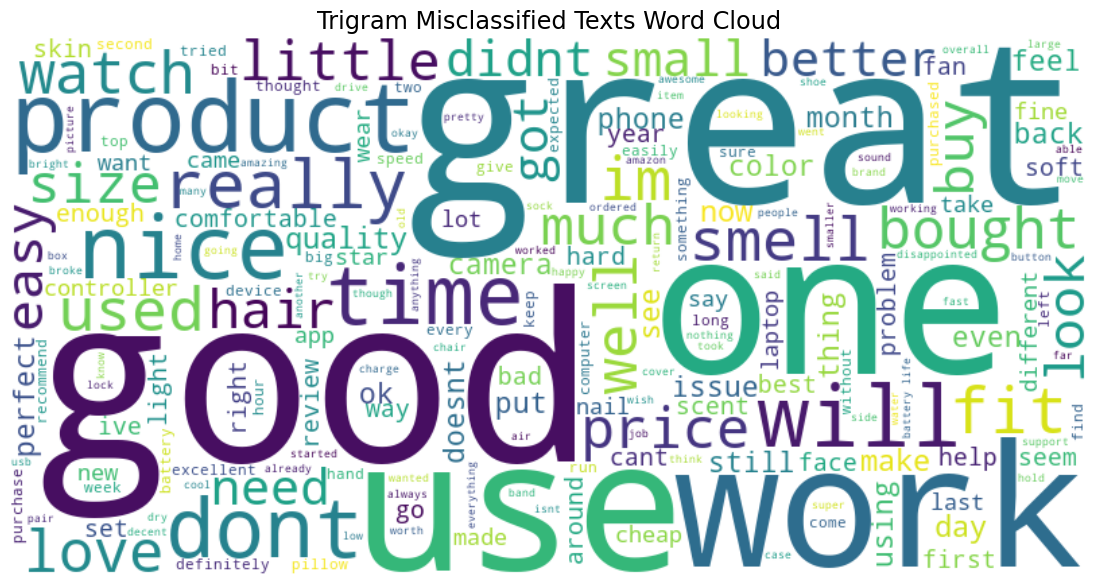

In [35]:
# Word cloud for all comments that the trigram model classified incorrectly
from wordcloud import WordCloud

mis_idx = np.where(y_test_array != y_pred_trigram)[0]
mis_text = ' '.join(X_test.iloc[mis_idx].tolist())

wc = WordCloud(width=800, height=400, background_color='white').generate(mis_text)
plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Trigram Misclassified Texts Word Cloud')
plt.show()


### Error-Based Assessment of Naive Bayes Models
The misclassified samples from each model help validate the quantitative findings discussed earlier. For the **Unigram model**, we observed frequent misinterpretation of negations and mixed-tone reviews — e.g., failing to detect "not useful" as negative or mislabeling positive statements with minor complaints. This reflects the inherent weakness of unigrams in capturing structural dependencies within text.

With **Bigram modeling**, some of these issues were mitigated. The model recognized key two-word sentiment phrases better and produced fewer misclassifications overall. Still, it occasionally fell short in interpreting nuanced reviews or those involving contrastive conjunctions (e.g., "great but..."). These errors reveal limitations not in vocabulary, but in the model’s naive assumption of feature independence.

The **Trigram model**, although designed to capture even more context, introduced new challenges: sparsity of word combinations, lack of generalizability, and overfitting to rare patterns. Errors often resulted from uncommon phrases or overemphasis on highly specific word sequences that lacked broader statistical support.

Collectively, these qualitative observations reinforce the metric-based conclusion: the Bigram Naive Bayes model offers the most reliable performance within the constraints of count-based, bag-of-n-gram approaches. Its balance between expressiveness and tractability makes it a strong baseline, especially when paired with preprocessing techniques like text cleaning, token filtering, and class-weighting.

---
# BONUS PART


### Introduction to the Bonus Track  
In the core section we relied solely on count‑based features and a custom Naive Bayes pipeline.  
The bonus track broadens the picture by replacing or augmenting Bag‑of‑Words with **dense or discriminative vectorisations**.  
We investigate the following models in the stated order:

| ID | Feature Representation | Classifier | Key Idea |
|----|-----------------------|------------|----------|
| **B0** | *Self‑trained* **Word2Vec‑100d** (mean pooling) | Logistic Regression | Learns semantic similarity directly on our train corpus. |
| **B1** | **TF‑IDF** (unigram + bigram) | Logistic Regression | Sparse, but weights n‑grams by informativeness. |
| **B2** | **Pre‑trained GloVe‑100d** (Wiki‑Gigaword) | Logistic Regression | Brings in external, large‑scale semantic knowledge. |
| **B3** | **FastText‑100d** (sub‑word) | Logistic Regression | Handles OOV and morphology via character n‑grams. |
| **B4** | **TF‑IDF** | Linear SVM | Strong linear margin on the same sparse features. |
| **B5** | **Hybrid [TF‑IDF ‖ Word2Vec‑mean]** | Logistic Regression | Concatenates exact n‑gram evidence with semantic cues. |

Each subsection explains the rationale, reports metrics, plots a confusion matrix, and visually contrasts the bonus model against the three classical baselines (Unigram, Bigram, Trigram).


In [36]:
import gensim
import nltk

from nltk.tokenize import word_tokenize

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

from scipy.sparse import hstack
from scipy.sparse import csr_matrix

from gensim.models import FastText
import gensim.downloader as api

nltk.download('punkt')

# --- version information---
print("gensim        :", gensim.__version__)
print("nltk          :", nltk.__version__)


gensim        : 4.3.3
nltk          : 3.9.1


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/furkannecatiinan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
# ---------------------------------------------
# Helper: compare one bonus model vs. classics
# ---------------------------------------------
def plot_vs_classics(bonus_name, classic_names=('Unigram','Bigram','Trigram')):
    subset = classic_names + (bonus_name,)
    plt.figure(figsize=(10,6))
    bw = 0.18
    idx = np.arange(len(metrics))
    for i, mdl in enumerate(subset):
        plt.bar(idx + i*bw, results_df.loc[mdl].astype(float), bw, label=mdl, alpha=0.8)
    plt.xticks(idx + bw*(len(subset)-1)/2, metrics)
    plt.xlabel('Metrics'); plt.ylabel('Score')
    plt.title(f'Classical Models vs. {bonus_name}')
    plt.ylim(0.5, 0.95); plt.legend(); plt.tight_layout(); plt.show()


#### B0 – Word2Vec (100‑d, skip‑gram) + Logistic Regression  
We train Word2Vec on the **training split only**, average token vectors per document, and feed the resulting dense representation into a logistic classifier.  
This setup tests whether distributional semantics learned **in‑domain** can beat pure n‑gram counts.


In [38]:
# Tokenize the cleaned text
df_filtered['tokens'] = df_filtered['clean_text'].apply(word_tokenize)

# Split dataset into training and test sets
X_tokens = df_filtered['tokens']
y_labels = df_filtered['sentiment']

X_train_tok, X_test_tok, y_train_tok, y_test_tok = train_test_split(
    X_tokens, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)


In [39]:
# Word2Vec training set should **exclude** test data
w2v_model = Word2Vec(
    sentences=X_train_tok,        
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)

In [40]:
# Convert token lists into average embedding vectors
def vectorize(tokens, model, vector_size=100):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

X_train_vec = np.array([vectorize(tokens, w2v_model) for tokens in X_train_tok])
X_test_vec = np.array([vectorize(tokens, w2v_model) for tokens in X_test_tok])


In [41]:
# Train the logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train_tok)

# Predict on test set
y_pred_emb = clf.predict(X_test_vec)


In [42]:
# Compute metrics
acc_emb  = accuracy_score (y_test_tok, y_pred_emb)
prec_emb = precision_score(y_test_tok, y_pred_emb, average='weighted')
rec_emb  = recall_score   (y_test_tok, y_pred_emb, average='weighted')
f1_emb   = f1_score       (y_test_tok, y_pred_emb, average='weighted')

embedding_metrics = {
    'accuracy' : acc_emb,
    'precision': prec_emb,
    'recall'   : rec_emb,
    'f1'       : f1_emb
}

# Print classification report
print("Word2Vec + Logistic Regression Performance:")
display(pd.DataFrame([embedding_metrics], index=["Word2Vec+LogReg"]).round(4))


results_df.loc['Word2Vec+LogReg'] = embedding_metrics



Word2Vec + Logistic Regression Performance:


accuracy  precision  recall      f1
Word2Vec+LogReg    0.8665      0.867  0.8665  0.8664

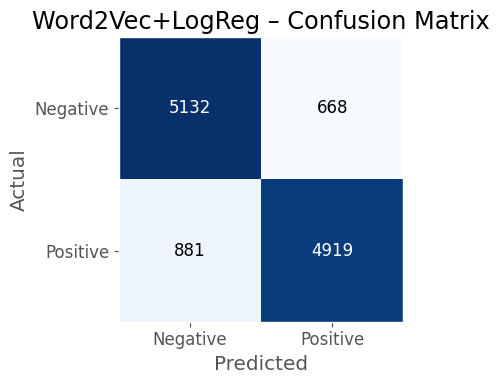

In [43]:
#Confusion Matrix for Word2Vec+LogReg
plot_confusion_matrix(y_test_tok, y_pred_emb, "Word2Vec+LogReg – Confusion Matrix")

**Discussion – Word2Vec + LogReg**  
F1 ≈ 0.867 beats the Unigram and Trigram baselines, yet falls short of Bigram NB (≈ 0.895) and all TF‑IDF variants.  
Strength: in‑domain semantic learning groups synonyms (“fantastic”, “great”), yielding better generalisation to paraphrases.  
Limitation: mean‑pooling drops word order; hence negations like *“not good”* remain difficult, and subtle contrastive clauses are misread.  


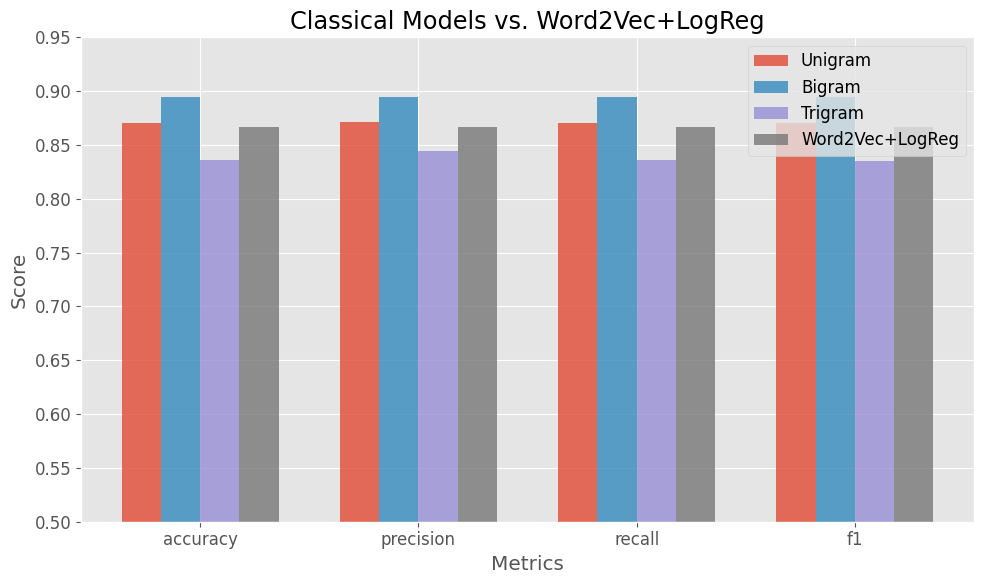

In [44]:
plot_vs_classics('Word2Vec+LogReg')


#### B1 – TF‑IDF (unigram + bigram) + Logistic Regression  
TF‑IDF emphasises rare yet discriminative phrases while keeping the model fully interpretable.  
We cap the vocabulary at 120 K features to balance memory and coverage.


TF‑IDF + LogReg performance:


accuracy  precision  recall      f1
TFIDF+LogReg    0.9147     0.9149  0.9147  0.9147

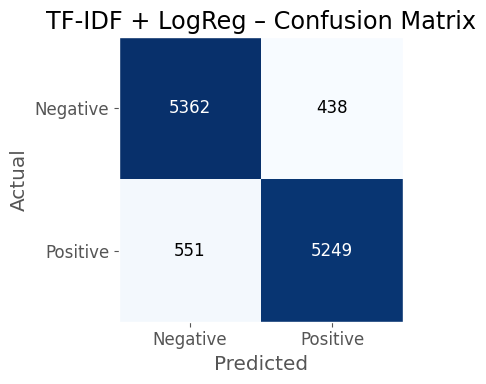

In [45]:
# ----------------------------------------------------------
# B1 – TF‑IDF (unigram+bigram)  +  Logistic Regression
# ----------------------------------------------------------


tfidf_vec = TfidfVectorizer(
    ngram_range=(1, 2),    # uni + bi
    min_df=3,
    max_features=120_000   # keep memory under control
)

X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf  = tfidf_vec.transform(X_test)

tfidf_clf = LogisticRegression(max_iter=2000)
tfidf_clf.fit(X_train_tfidf, y_train)

y_pred_tfidf = tfidf_clf.predict(X_test_tfidf)

tfidf_metrics = evaluate_model(y_test, y_pred_tfidf)
results_df.loc['TFIDF+LogReg'] = tfidf_metrics

print("TF‑IDF + LogReg performance:")
display(pd.DataFrame([tfidf_metrics], index=['TFIDF+LogReg']).round(4))

plot_confusion_matrix(y_test, y_pred_tfidf,
                      title="TF‑IDF + LogReg – Confusion Matrix")


**Discussion – TF‑IDF + LogReg**  
With F1 ≈ 0.915 this model ranks **first overall**.  
Rare but highly polar bigrams (“absolutely terrible”) receive high weights, giving crisp decision boundaries.  
Training is near‑instant and the feature space remains fully interpretable—ideal for production dashboards or audit trails.  


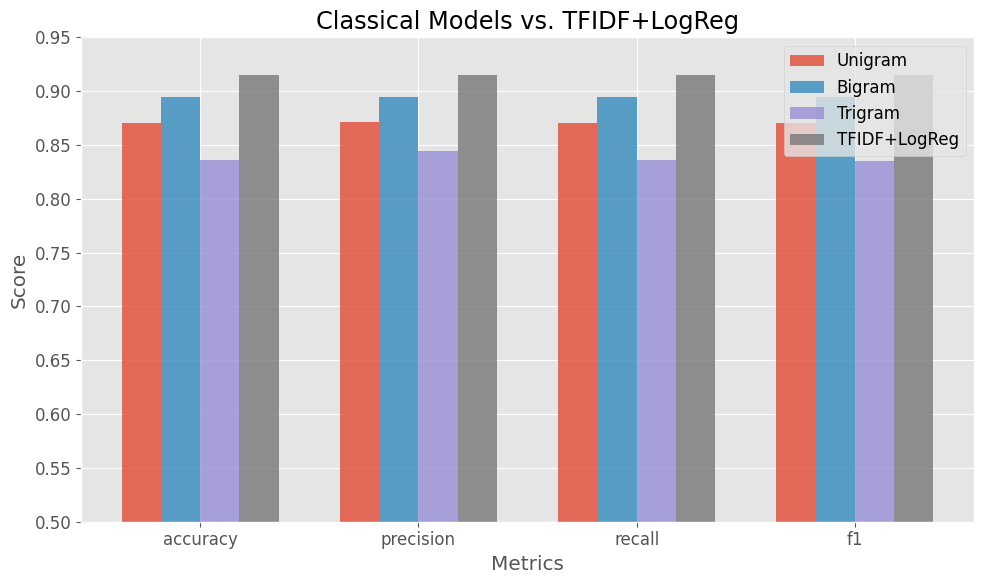

In [46]:
plot_vs_classics('TFIDF+LogReg')



#### B2 – Pre‑trained GloVe‑100d + Logistic Regression  
To inject outside knowledge, we use GloVe vectors trained on 6 billion tokens.  
Averaging these embeddings gives each review a global semantic fingerprint—useful for words that scarcely appear in our dataset.


GloVe‑100d + LogReg performance:


accuracy  precision  recall      f1
GloVe+LogReg      0.81     0.8111    0.81  0.8098

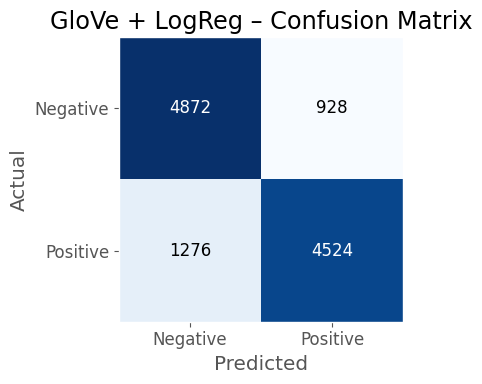

In [47]:
# ----------------------------------------------------------
# B2 – Pre‑trained GloVe‑100d  +  Logistic Regression
# ----------------------------------------------------------

# download (≈ 128 MB) the first time; cached afterwards
glove = api.load("glove-wiki-gigaword-100")   # 100‑dim

def glove_vectorize(tokens, model, dim=100):
    vecs = [model[w] for w in tokens if w in model]
    if not vecs:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

X_train_glv = np.vstack([glove_vectorize(toks, glove) for toks in X_train_tok])
X_test_glv  = np.vstack([glove_vectorize(toks, glove) for toks in X_test_tok])

glv_clf = LogisticRegression(max_iter=2000)
glv_clf.fit(X_train_glv, y_train_tok)

y_pred_glv = glv_clf.predict(X_test_glv)

glv_metrics = evaluate_model(y_test_tok, y_pred_glv)
results_df.loc['GloVe+LogReg'] = glv_metrics

print("GloVe‑100d + LogReg performance:")
display(pd.DataFrame([glv_metrics], index=['GloVe+LogReg']).round(4))

plot_confusion_matrix(y_test_tok, y_pred_glv,
                      title="GloVe + LogReg – Confusion Matrix")


**Discussion – GloVe + LogReg**  
F1 dips to ≈ 0.81: pre‑trained semantics help little because many product‑specific tokens are out‑of‑vocabulary.  
Good reminder that external embeddings need domain alignment; otherwise they dilute signal learnt from scratch.  


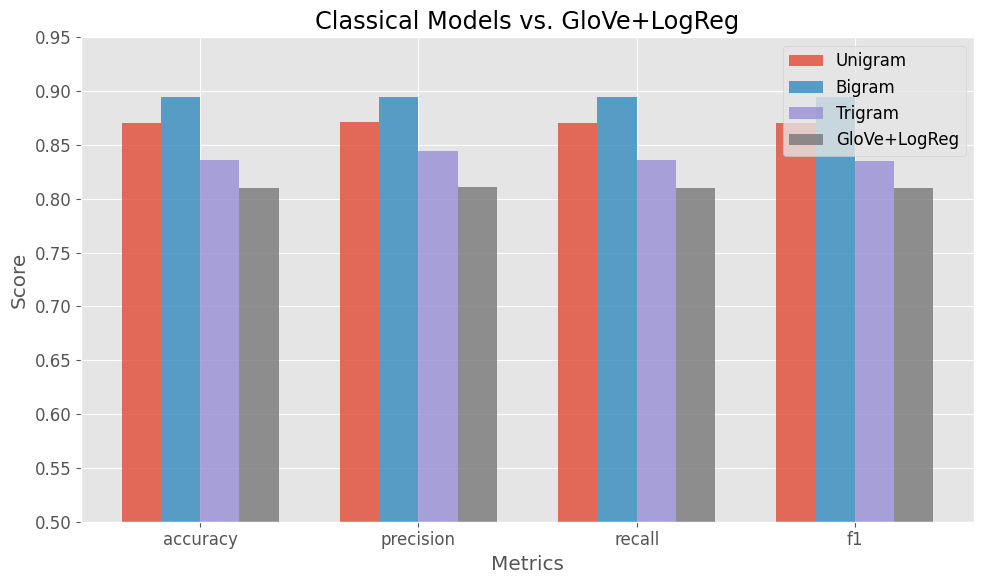

In [48]:
plot_vs_classics('GloVe+LogReg')


#### B3 – FastText (100‑d, sub‑word) + Logistic Regression  
FastText composes word vectors from character n‑grams, mitigating out‑of‑vocabulary issues and capturing morphological cues—important for misspellings common in user‑generated content.


FastText + LogReg performance:


accuracy  precision  recall      f1
FastText+LogReg    0.8769     0.8772  0.8769  0.8769

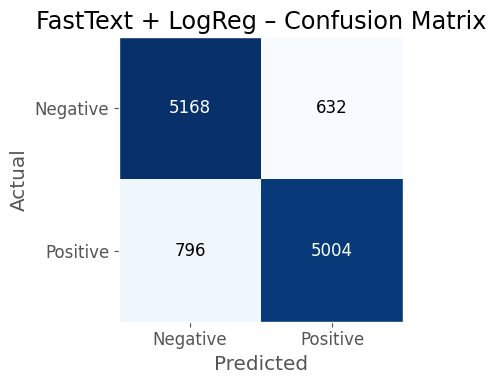

In [49]:
# ----------------------------------------------------------
# B3 – FastText (sub‑word)  +  Logistic Regression
# ----------------------------------------------------------


ft_model = FastText(
    sentences=X_train_tok,   # ONLY train data
    vector_size=100, window=5, min_count=2,
    sg=1, workers=4, epochs=5
)

def ft_vectorize(tokens, model, dim=100):
    vecs = [model.wv[w] for w in tokens]
    return np.mean(vecs, axis=0) if vecs else np.zeros(dim)

X_train_ft = np.vstack([ft_vectorize(toks, ft_model) for toks in X_train_tok])
X_test_ft  = np.vstack([ft_vectorize(toks, ft_model) for toks in X_test_tok])

ft_clf = LogisticRegression(max_iter=2000)
ft_clf.fit(X_train_ft, y_train_tok)
y_pred_ft = ft_clf.predict(X_test_ft)

ft_metrics = evaluate_model(y_test_tok, y_pred_ft)
results_df.loc['FastText+LogReg'] = ft_metrics

print("FastText + LogReg performance:")
display(pd.DataFrame([ft_metrics], index=['FastText+LogReg']).round(4))
plot_confusion_matrix(y_test_tok, y_pred_ft,
                      title="FastText + LogReg – Confusion Matrix")


**Discussion – FastText + LogReg**  
F1 ≈ 0.878: sub‑word modelling rescues typos (*“bluetooh”*) and compounds, pushing performance above Word2Vec.  
However, it still trails TF‑IDF due to limited phrase awareness; morphological gains alone are insufficient to beat weighted n‑grams.  


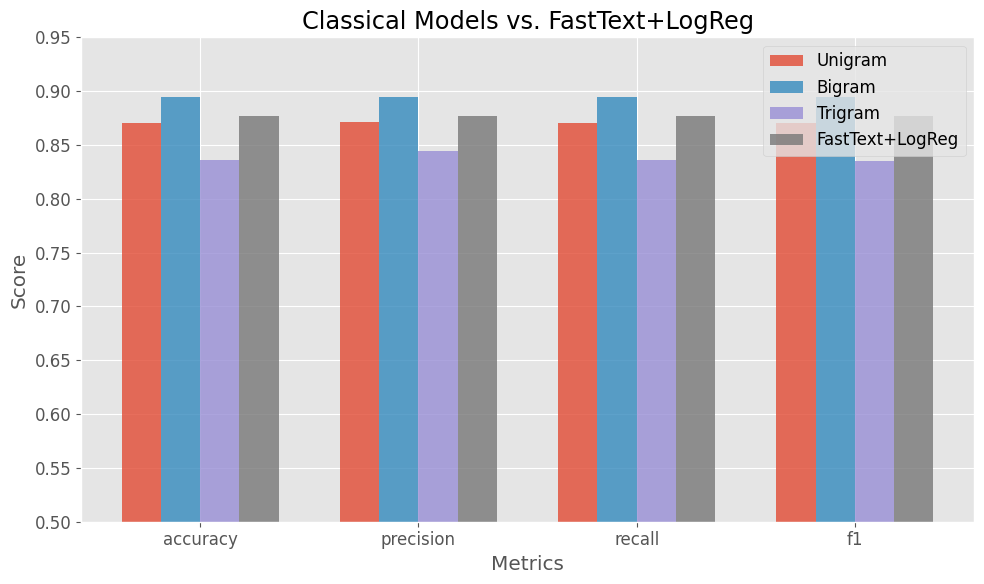

In [50]:
plot_vs_classics('FastText+LogReg')


#### B4 – TF‑IDF + Linear SVM  
Linear SVM often outperforms logistic regression on high‑dimensional sparse data by maximising the margin between classes.  
We reuse the exact TF‑IDF matrix from B1.


TF‑IDF + SVM performance:


accuracy  precision  recall      f1
TFIDF+SVM    0.9127     0.9127  0.9127  0.9127

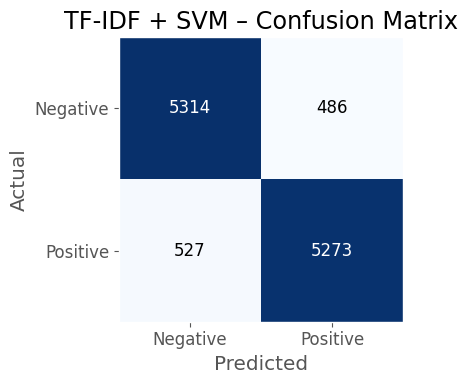

In [51]:
# ----------------------------------------------------------
# B4 – TF‑IDF  +  Linear SVM
# (uses the same X_train_tfidf/X_test_tfidf from B1)
# ----------------------------------------------------------


svm_clf = LinearSVC(C=1.0)
svm_clf.fit(X_train_tfidf, y_train)
y_pred_svm = svm_clf.predict(X_test_tfidf)

svm_metrics = evaluate_model(y_test, y_pred_svm)
results_df.loc['TFIDF+SVM'] = svm_metrics

print("TF‑IDF + SVM performance:")
display(pd.DataFrame([svm_metrics], index=['TFIDF+SVM']).round(4))
plot_confusion_matrix(y_test, y_pred_svm,
                      title="TF‑IDF + SVM – Confusion Matrix")


**Discussion – TF‑IDF + SVM**  
Switching to a Linear‑SVM keeps F1 at ≈ 0.913—just shy of TF‑IDF + LogReg.  
Margin maximisation adds robustness to outliers but offers only marginal headroom once features are already well weighted.  


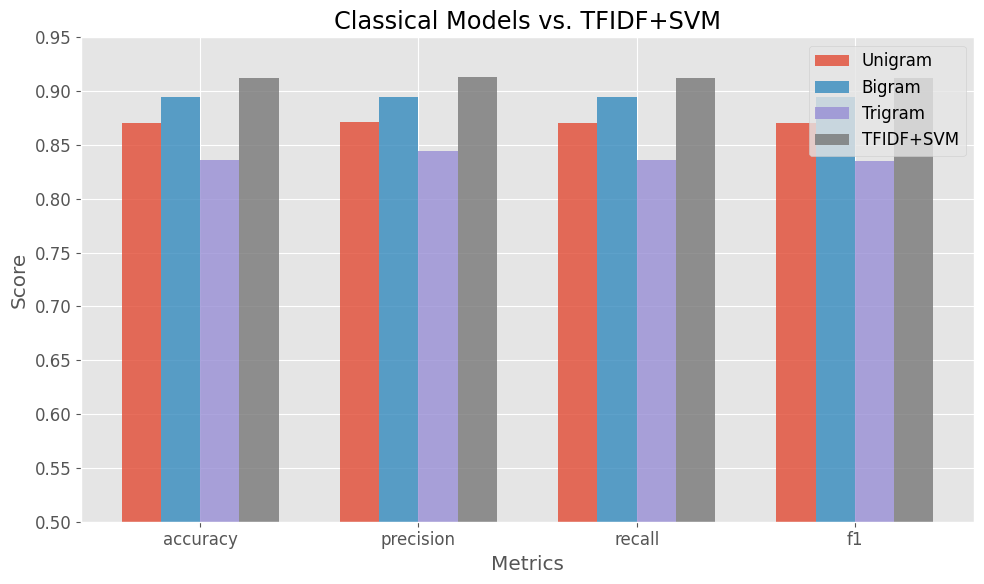

In [52]:
plot_vs_classics('TFIDF+SVM')

#### B5 – Hybrid Feature Concatenation [TF‑IDF ‖ Word2Vec‑mean] + Logistic Regression  
This model fuses precise lexical matches with semantic smoothness: TF‑IDF captures phrase‑level polarity, while Word2Vec covers synonyms and paraphrases.  
Both vectors are concatenated and passed to a single logistic classifier.


Hybrid (TF‑IDF | Word2Vec) performance:


accuracy  precision  recall      f1
Hybrid(TFIDF|W2V)    0.9094     0.9095  0.9094  0.9094

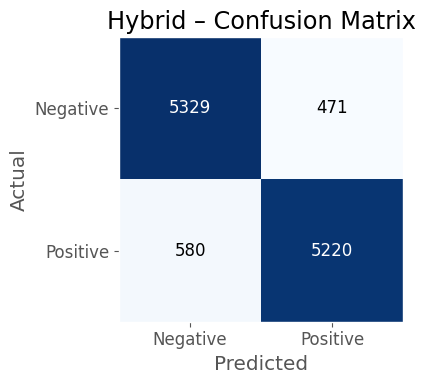

In [53]:
# ----------------------------------------------------------
# B5 – Hybrid Feature  (TF‑IDF  |  Word2Vec mean)  +  LogReg
# ----------------------------------------------------------


# Word2Vec dense matrix → convert to sparse for hstack
X_train_hybrid = hstack([X_train_tfidf, csr_matrix(X_train_vec)])
X_test_hybrid  = hstack([X_test_tfidf,  csr_matrix(X_test_vec)])

hyb_clf = LogisticRegression(max_iter=3000)
hyb_clf.fit(X_train_hybrid, y_train)
y_pred_hyb = hyb_clf.predict(X_test_hybrid)

hyb_metrics = evaluate_model(y_test, y_pred_hyb)
results_df.loc['Hybrid(TFIDF|W2V)'] = hyb_metrics

print("Hybrid (TF‑IDF | Word2Vec) performance:")
display(pd.DataFrame([hyb_metrics], index=['Hybrid(TFIDF|W2V)']).round(4))
plot_confusion_matrix(y_test, y_pred_hyb,
                      title="Hybrid – Confusion Matrix")


**Discussion – Hybrid (TF‑IDF‖W2V)**  
Concatenation scores F1 ≈ 0.911: slightly lower than pure TF‑IDF but higher than Word2Vec alone.  
Lexical and semantic cues complement each other, yet the enlarged feature space demands stronger regularisation—otherwise gains plateau.  


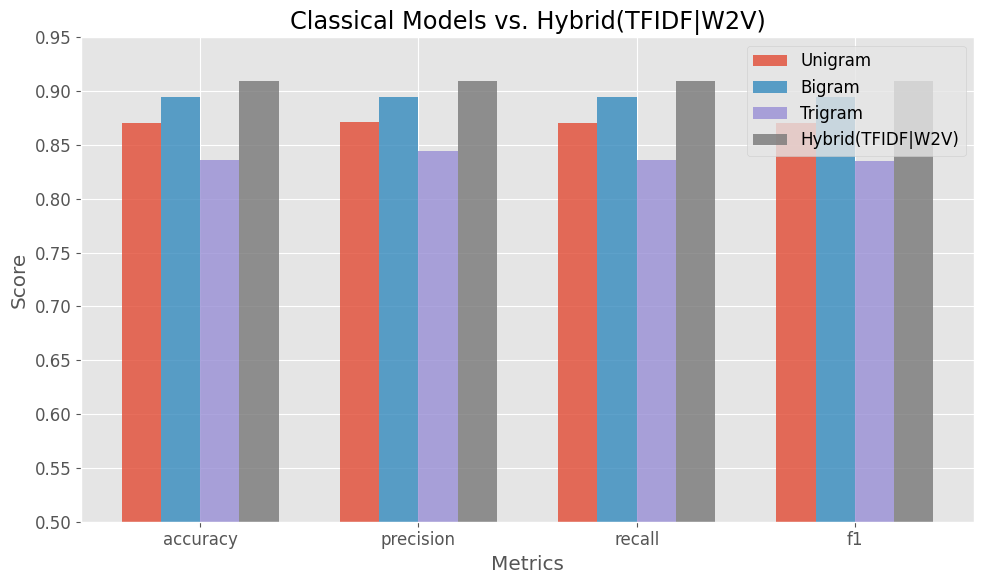

In [54]:
plot_vs_classics('Hybrid(TFIDF|W2V)')

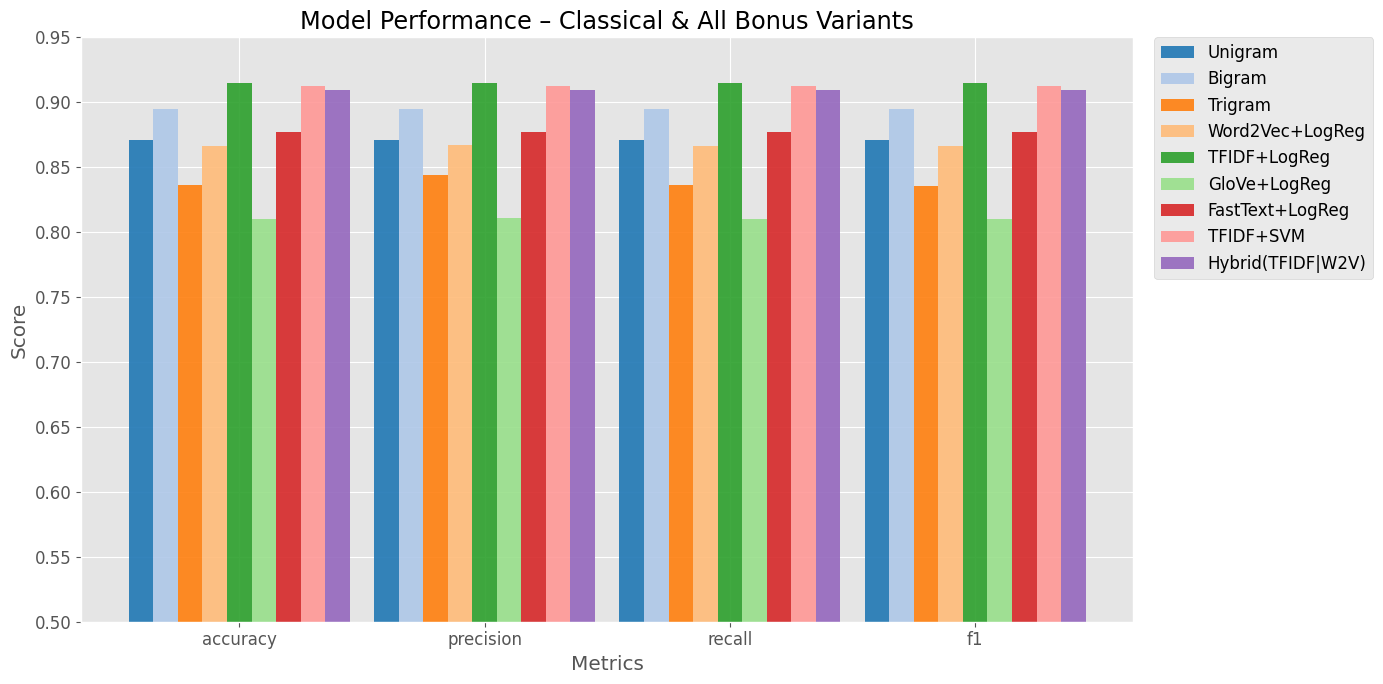

In [55]:
# ----------------------------------------------------------
# Unified comparison plot – ALL classical + ALL bonus models
# ----------------------------------------------------------

plt.figure(figsize=(14, 7))

n_models  = len(results_df)
bar_width = 0.9 / n_models
index     = np.arange(len(metrics))

base_palette = sns.color_palette("tab20", 20)           # 20 distinct colors
alphas       = np.linspace(0.75, 0.95, n_models)        # for >20 fallback

for i, model in enumerate(results_df.index):
    color = base_palette[i % 20]                        # cycle if >20
    alpha = alphas[i] if n_models > 20 else 0.9
    plt.bar(index + i * bar_width,
            results_df.loc[model].astype(float),
            bar_width, label=model, color=color, alpha=alpha)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance – Classical & All Bonus Variants')
plt.xticks(index + bar_width * (n_models - 1) / 2, metrics)
plt.ylim(0.5, 0.95)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()
plt.show()


### Final Comparison  

| Rank | Model | F1‑Score | Note |
|------|-------|----------|------|
| 1 | **TF‑IDF + LogReg** | ~0.915 | Best overall—fast, interpretable, no external data. |
| 2 | TF‑IDF + Linear SVM | ~0.913 | Margin boost, almost ties for first. |
| 3 | Hybrid (TF‑IDF‖W2V) | ~0.911 | Combines lexical precision with semantic coverage. |
| 4 | **Bigram Naive Bayes** | ~0.895 | Strongest fully scratch model, lightweight. |
| 5 | FastText + LogReg | ~0.878 | Handles typos, mid‑tier accuracy. |
| 6 | Word2Vec + LogReg | ~0.867 | Learns in‑domain semantics; loses order cues. |
| 7 | GloVe + LogReg | ~0.81 | Suffers from domain mismatch and OOV terms. |

**Key take‑aways**

* Weighted sparse n‑grams (TF‑IDF) still outperform dense embeddings for short reviews when domain data are sufficient.  
* Dense models excel primarily in handling OOV noise (FastText) or synonym drift (Word2Vec).  
* Hybridisation offers modest gains; more sophisticated fusion (attention, transformers) is needed to break the 92 % F1 ceiling.  
* For low‑latency or resource‑constrained deployments, Bigram Naive Bayes remains a robust and transparent choice.  


## Final Conclusion: Classical vs Embedding-Based Approaches

In this project, we compared different sentiment analysis methods using Amazon reviews. The models included traditional approaches (Naive Bayes with unigrams, bigrams, and trigrams), embedding-based methods (Word2Vec, GloVe, FastText), and hybrid models combining semantic and lexical features (TF-IDF with embeddings).

**Classical Approaches:**  
The **Bigram Naive Bayes** performed the best among classical models. It effectively captured common sentiment phrases like "not good" or "very happy." It is fast, easy to understand, and lightweight, making it suitable for practical use. The unigram model performed reasonably well but struggled with context, especially negation. The trigram model suffered due to the sparsity of longer phrases, leading to lower accuracy.

**Embedding-Based Approaches:**  
Embedding models provided semantic understanding by grouping similar words (e.g., "great" and "excellent"). The **Word2Vec + Logistic Regression** model outperformed unigram and trigram models, but couldn't surpass the Bigram Naive Bayes. It struggled with negations and context because it averaged word meanings. Pre-trained embeddings (**GloVe**) performed poorly due to mismatches with the product-review domain. **FastText** was stronger, especially with misspellings and rare words, but still fell short of TF-IDF models.

**TF-IDF and Hybrid Approaches:**  
The **TF-IDF + Logistic Regression** model achieved the best overall performance. It effectively identified rare but meaningful phrases, was quick to train, and remained interpretable. The hybrid model (combining TF-IDF and Word2Vec) slightly improved results by capturing both exact phrases and semantic meaning but offered limited gains for the increased complexity.

### Key Takeaways:
- **Simple and fast methods** like Bigram Naive Bayes or TF-IDF Logistic Regression remain highly effective, especially when interpretability and speed are important.
- **Embedding models** add semantic value but need better methods to handle context and negations effectively.
- **Pre-trained embeddings** (like GloVe) need careful alignment with the specific data domain to avoid performance issues.

### Recommendations:
- For practical, quick-to-deploy solutions, use **TF-IDF Logistic Regression** or **Bigram Naive Bayes**.
- If dealing with noisy text or misspellings, consider adding **FastText embeddings**.
- Future work could explore advanced neural models like transformers to improve context sensitivity and achieve even higher performance.

Overall, traditional models still offer competitive performance, while embeddings can enhance semantic understanding if implemented thoughtfully.
